## T-SNE on Amazon food reviews

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [2]:
#getting Cleaned data from Reviews table
conn = sqlite3.connect('final.sqlite')
final_amazon = pd.read_sql_query("""
SELECT *
FROM Reviews
""", conn) 

In [3]:
#importing TSNE
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as MTSNE

In [4]:
#stacking with score
def Stacking_df(x,y):
    '''
    return dataframe after concatinating  and y
    '''
    out_2d5 = np.hstack((x,y))
    return pd.DataFrame(out_2d5,columns=['one','two','score'])

While searching for optimization of tsne issues for Sklean i found intersting post https://github.com/scikit-learn/scikit-learn/issues/10044 , https://gist.github.com/lmcinnes/023443d7e249689cb968f36570447950 after that i checked with iris data with both `Sklearn` and `Multicore-TSNE` and results are much similar and and found resutls as below.

In [4]:
col = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width','species']

In [5]:
#Reading iris data
dta = pd.read_csv(
'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,names=col)

In [6]:
dta.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [7]:
%%timeit
X = TSNE(n_components=2,perplexity=30,n_iter=1000).\
fit_transform(dta[['sepal_length', 'sepal_width',
                   'petal_length', 'petal_width']])

1.88 s ± 167 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
X = TSNE(n_components=2,perplexity=30,n_iter=1000).\
fit_transform(dta[['sepal_length', 'sepal_width',
                   'petal_length', 'petal_width']])

In [9]:
out = np.hstack((X,dta['species'].values.reshape(-1,1)))
df = pd.DataFrame(out,columns=['one','two','species'])

Text(0.5,1,'Sklearn')

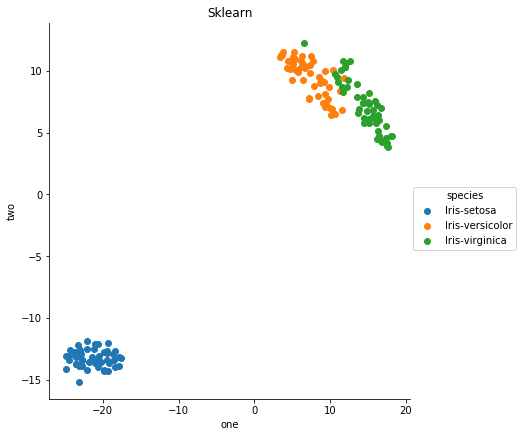

In [10]:
sns.FacetGrid(df, hue="species", size=6).\
map(plt.scatter,'one','two').add_legend()
plt.title('Sklearn')

In [11]:
%%timeit
Y = MTSNE(n_components=2,perplexity=30,n_iter=1000).\
fit_transform(dta[['sepal_length', 'sepal_width',
                   'petal_length', 'petal_width']])

232 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
Y = MTSNE(n_components=2,perplexity=30,n_iter=1000).\
fit_transform(dta[['sepal_length', 'sepal_width',
                   'petal_length', 'petal_width']])

In [13]:
out1 = np.hstack((Y,dta['species'].values.reshape(-1,1)))
df1 = pd.DataFrame(out,columns=['one','two','species'])

Text(0.5,1,'Multicore TSNE')

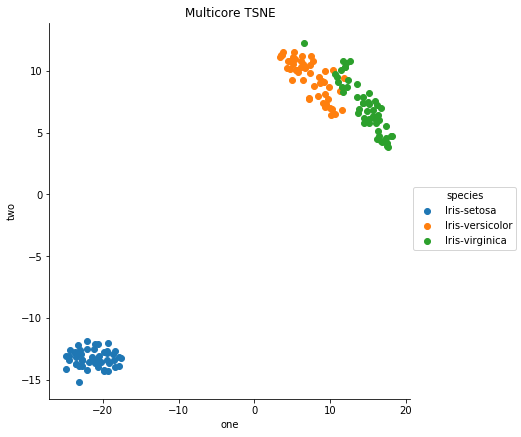

In [14]:
sns.FacetGrid(df1, hue="species", size=6).\
map(plt.scatter,'one','two').add_legend()
plt.title('Multicore TSNE')

### Bag of Words:<br>

Cleaned data is in CleanedTextBow column of final_amazon data frame.<br>
for Bag of Words doing count vectorizer from scikit learn.

In [4]:
#for BoW
count_vect = CountVectorizer(dtype=np.int8) #in scikit-learn
final_counts = count_vect.fit_transform(
    final_amazon['CleanedTextBow'].values)

In [5]:
#Shape of sparse matrix
final_counts.get_shape()

(364171, 108358)

Because of large dataset and lack of powerful processor addressed issues with below two methods<br>
* Did TruncatedSVD ,got dimentions to 50 and then used that data to plot T-SNE.
* Sampled data from original data and then used sampled data to plot T-SNE

##### 1. SVD for Total data then TSNE

In [6]:
#Trucated SVD for dimentonality reduction
svd = TruncatedSVD(n_components=50, n_iter=7, 
                   random_state=42).fit(final_counts)
X_svd = svd.transform(final_counts)

Text(0,0.5,'% of data')

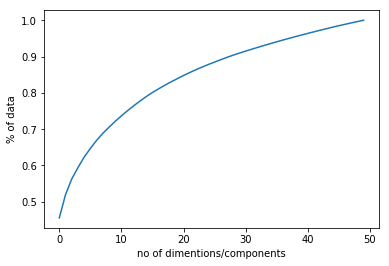

In [8]:
plt.plot(np.cumsum(svd.explained_variance_/np.sum(
                            svd.explained_variance_)))
plt.xlabel('no of dimentions/components')
plt.ylabel('% of data')

In [7]:
scaler = StandardScaler()
X_svd_scale=scaler.fit_transform(X_svd)

In [24]:
#TSNE for SVD data
final_2d = MTSNE(n_components=2,perplexity=30,n_iter=1000,
                 n_jobs=8).fit_transform(X_svd_scale)

In [26]:
#stacking wit score for visualization
out_2d = np.hstack((final_2d,final_amazon.Score.values.reshape(-1,1)))
#creating dataframe
df_2d = pd.DataFrame(out_2d,columns=['one','two','score'])

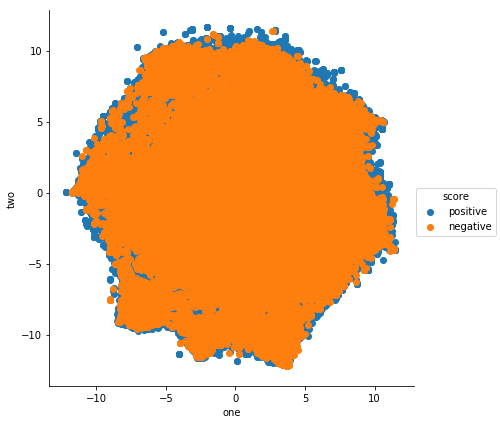

In [27]:
#Scatter plot for TSNE in 2d
sns.FacetGrid(df_2d, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [28]:
#TSNE with diierent n_iter
final_2d2 = MTSNE(n_components=2,perplexity=35,n_iter=1700,
                    n_jobs=8).fit_transform(X_svd_scale)

In [29]:
#stacking with score for visualization
out_2d2 = np.hstack((final_2d2,final_amazon.Score.values.reshape(-1,1)))
#Creating DataFrame
df_2d2 = pd.DataFrame(out_2d2,columns=['one','two','score'])

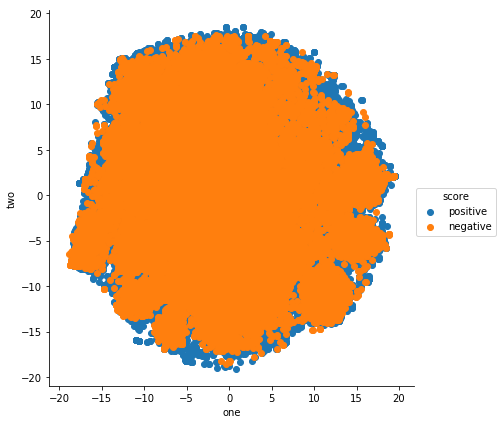

In [30]:
#scatter plot
sns.FacetGrid(df_2d2, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [31]:
#Checking with higher iterations
final_2d3 = MTSNE(n_components=2,perplexity=35,n_iter=2800,
                  n_jobs=8).fit_transform(X_svd_scale)

In [32]:
#stacking score for visualization
out_2d3 = np.hstack((final_2d3,final_amazon.Score.values.reshape(-1,1)))
#Creating DataFrame
df_2d3 = pd.DataFrame(out_2d3,columns=['one','two','score'])

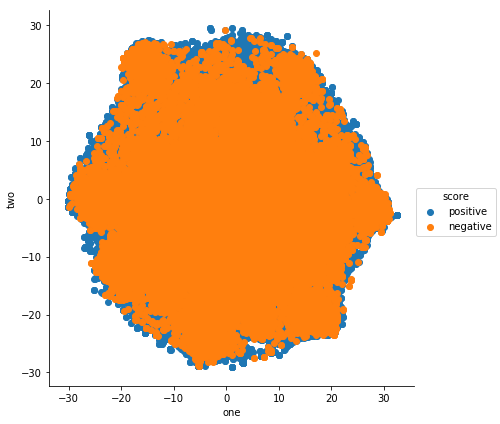

In [33]:
#Plot for TSNE
sns.FacetGrid(df_2d3, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [8]:
#TSNE with different perpleity
final_2d4 = MTSNE(n_components=2,perplexity=15,
                  n_iter=2800,n_jobs=8).fit_transform(X_svd_scale)

In [9]:
#Stacking wit Score
out_2d4 = np.hstack((final_2d4,final_amazon.Score.values.reshape(-1,1)))
#creating DataFrame
df_2d4 = pd.DataFrame(out_2d4,columns=['one','two','score'])

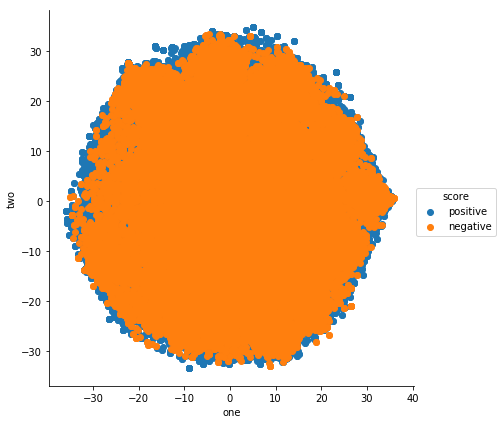

In [10]:
#plot for TSNE
sns.FacetGrid(df_2d4, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

##### 2. Sampled data then TSNE

In [4]:
#getting sample of Data
s = final_amazon.sample(n=25000)

In [5]:
#converting to BOW
count_vect = CountVectorizer(dtype=np.int8) #in scikit-learn
final_counts = count_vect.fit_transform(s['CleanedTextBow'].values)

In [6]:
#shape of BOW data
final_counts.get_shape()

(25000, 31257)

In [7]:
#converting to dense array
x = final_counts.toarray()

In [8]:
#scaling data
scaler = StandardScaler()
X_svd_scale=scaler.fit_transform(x)

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
#TSNE wit sampled data
final_2d4 = MTSNE(n_components=2,perplexity=30,n_iter=2800,
                  n_jobs=8).fit_transform(X_svd_scale)

In [18]:
#stacking with score
out_2d4 = np.hstack((final_2d4,s.Score.values.reshape(-1,1)))
#Creating DataFrame
df_2d4 = pd.DataFrame(out_2d4,columns=['one','two','score'])

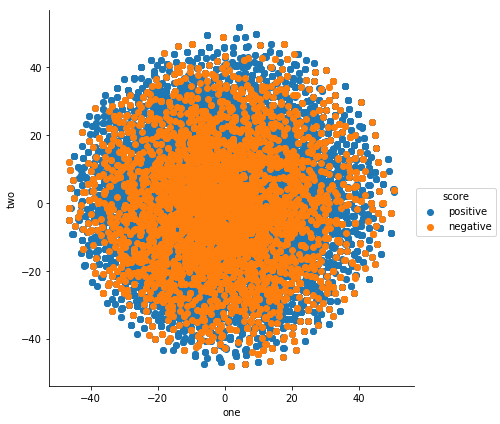

In [19]:
#Scatter plot
sns.FacetGrid(df_2d4, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [20]:
#TSNE with different params
final_2d5 = MTSNE(n_components=2,perplexity=50,n_iter=3200,
                  n_jobs=8).fit_transform(X_svd_scale)

In [21]:
#Stacking with score
out_2d5 = np.hstack((final_2d5,s.Score.values.reshape(-1,1)))
#Creating DataFrame
df_2d5 = pd.DataFrame(out_2d5,columns=['one','two','score'])

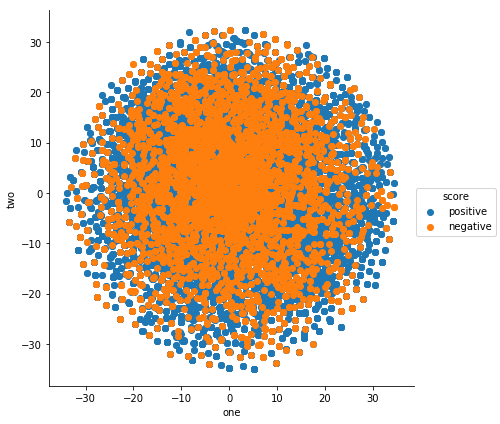

In [22]:
#Scatter Plot
sns.FacetGrid(df_2d5, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [9]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=42,n_iter=4500,
                  n_jobs=8).fit_transform(X_svd_scale)

In [10]:
#stacking with score
out_2d5 = np.hstack((final_2d5,s.Score.values.reshape(-1,1)))
#Creating DataFrame
df_2d5 = pd.DataFrame(out_2d5,columns=['one','two','score'])

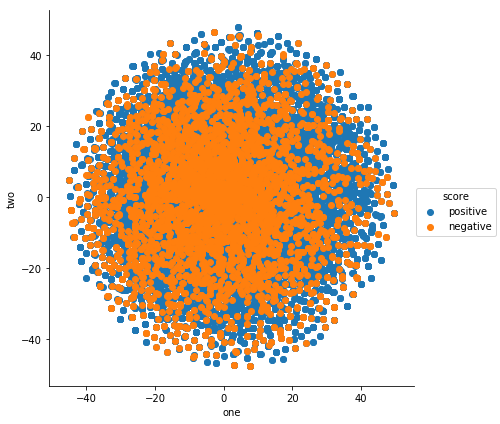

In [11]:
#Scatter Plot
sns.FacetGrid(df_2d5, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [12]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=42,n_iter=6500,
                  n_jobs=8).fit_transform(X_svd_scale)

In [13]:
#Stacking with Score
out_2d5 = np.hstack((final_2d5,s.Score.values.reshape(-1,1)))
df_2d5 = pd.DataFrame(out_2d5,columns=['one','two','score'])

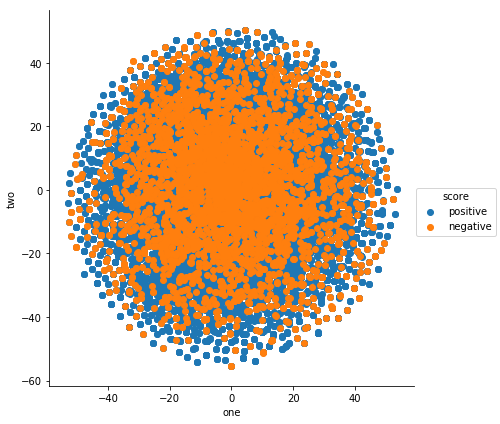

In [14]:
#Scatterplot
sns.FacetGrid(df_2d5, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [15]:
#TSNE wit less perpleity
final_2d5 = MTSNE(n_components=2,perplexity=8,n_iter=5000,
                  n_jobs=8).fit_transform(X_svd_scale)

In [16]:
#stacking with score
out_2d5 = np.hstack((final_2d5,s.Score.values.reshape(-1,1)))
df_2d5 = pd.DataFrame(out_2d5,columns=['one','two','score'])

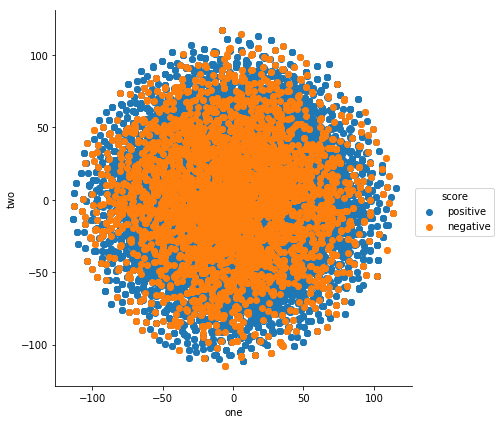

In [17]:
#Scatter plot
sns.FacetGrid(df_2d5, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

#### Observations-BOW:<br>
1. We can infer from above TSNE plots that data for both positive and negative reviews are so much overlapped.
2. Plot from first section after doing SVD for whole data is so much similar to sample data plots and checked wit different perflity and no of iterations.

### TF-IDF:<br>

In [4]:
#tf-idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(
               final_amazon['CleanedTextBow'].values)

In [5]:
#shape of tfidf
final_tf_idf.get_shape()

(364171, 2923705)

Because of large dataset and lack of powerful processor addressed issues with below two methods<br>
* Did TruncatedSVD ,got dimentions to 50 and then used that data to plot T-SNE.
* Sampled data from original data and then used sampled data to plot T-SNE

##### 1. using SVD and then TSNE for TFIDF vectors

In [5]:
#Trucated SVD for dimentonality reduction
svd = TruncatedSVD(n_components=150, n_iter=7, random_state=42).fit(final_tf_idf)
X_svd = svd.transform(final_tf_idf)

Text(0,0.5,'% of data')

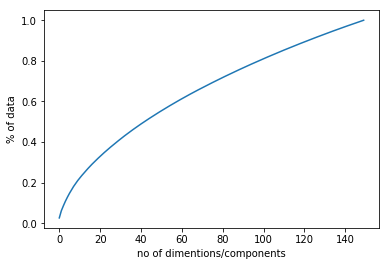

In [11]:
plt.plot(np.cumsum(svd.explained_variance_/np.sum(svd.explained_variance_)))
plt.xlabel('no of dimentions/components')
plt.ylabel('% of data')

In [6]:
scaler = StandardScaler()
X_svd_scale=scaler.fit_transform(X_svd)

In [13]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=32,n_iter=3200,
                  n_jobs=12).fit_transform(X_svd_scale)

In [4]:
#stacking with score
def Stacking_df(x,y):
    '''
    return dataframe after concatinating  and y
    '''
    out_2d5 = np.hstack((x,y))
    return pd.DataFrame(out_2d5,columns=['one','two','score'])

In [22]:
df = Stacking_df(final_2d5,final_amazon.Score.values.reshape(-1,1))

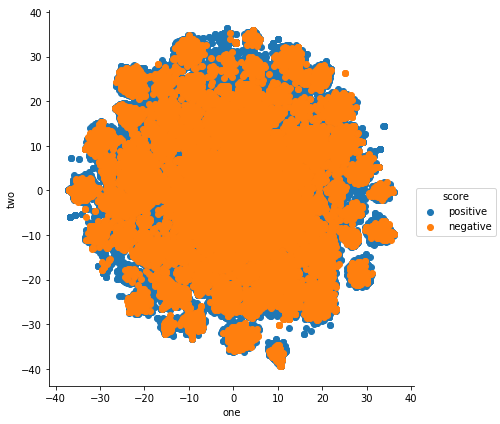

In [21]:
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [10]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=6,n_iter=1200,
                  n_jobs=12).fit_transform(X_svd_scale)

In [13]:
#Stacking df
df = Stacking_df(final_2d5,final_amazon.Score.values.reshape(-1,1))

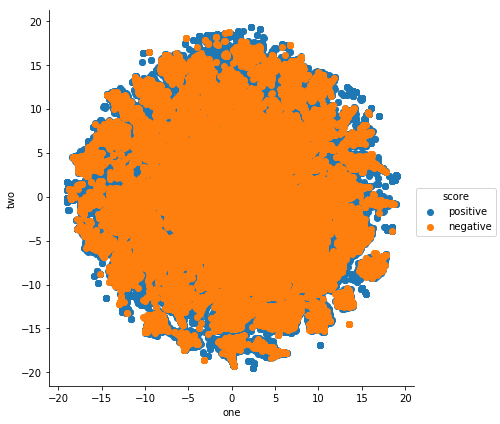

In [14]:
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [15]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=6,n_iter=5000,
                  n_jobs=12).fit_transform(X_svd_scale)

In [16]:
#Stacking df
df = Stacking_df(final_2d5,final_amazon.Score.values.reshape(-1,1))

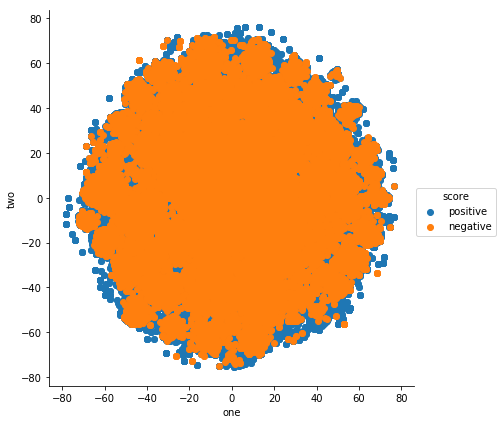

In [17]:
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [7]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=75,n_iter=5000,n_jobs=12).fit_transform(X_svd_scale)

In [10]:
#Stacking df
df = Stacking_df(final_2d5,final_amazon.Score.values.reshape(-1,1))

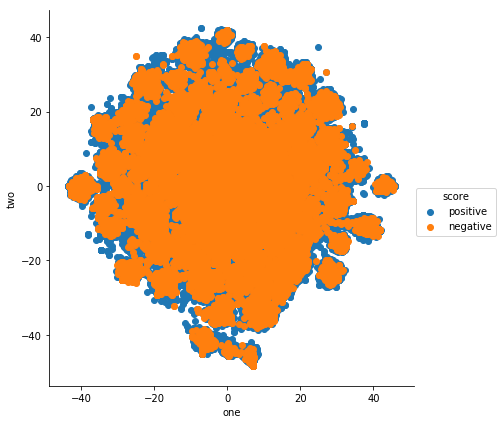

In [11]:
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

##### 2. Sapmpled and then T-SNE for TFIDF

In [5]:
#sampled df
s = final_amazon.sample(n=15000)

In [6]:
#tf-idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(
               s['CleanedTextBow'].values)

In [7]:
#shape
final_tf_idf.get_shape()

(15000, 359426)

In [10]:
#Trucated SVD for dimentonality reduction
svd = TruncatedSVD(n_components=160, n_iter=7, random_state=42).fit(final_tf_idf)
X_svd = svd.transform(final_tf_idf)

Text(0,0.5,'% of data')

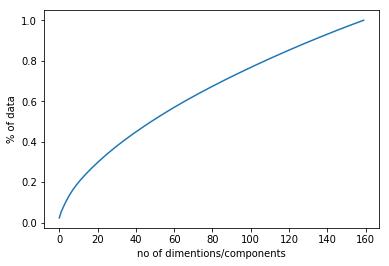

In [11]:
plt.plot(np.cumsum(svd.explained_variance_/np.sum(svd.explained_variance_)))
plt.xlabel('no of dimentions/components')
plt.ylabel('% of data')

In [12]:
scaler = StandardScaler()
X_svd_scale=scaler.fit_transform(X_svd)

In [13]:
#TSNE
final_2d5 = TSNE(n_components=2,perplexity=35,
                 n_iter=1800).fit_transform(X_svd_scale)

In [15]:
#Stacking df
df = Stacking_df(final_2d5,s.Score.values.reshape(-1,1))

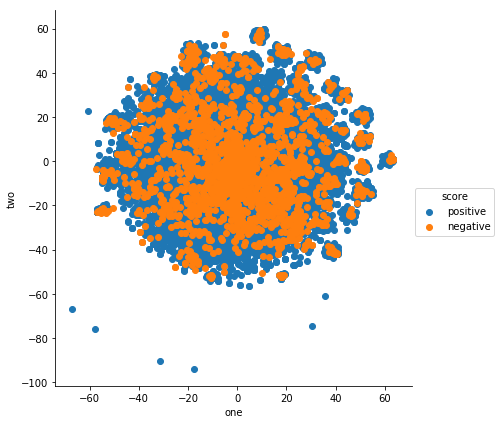

In [16]:
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [17]:
#TSNE
final_2d5 = TSNE(n_components=2,perplexity=35,
                 n_iter=3500).fit_transform(X_svd_scale)

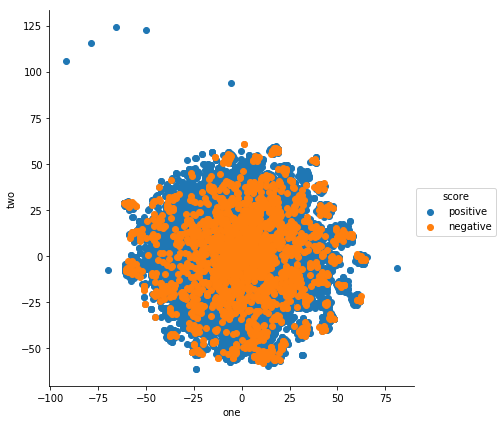

In [18]:
#Stacking df
df = Stacking_df(final_2d5,s.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

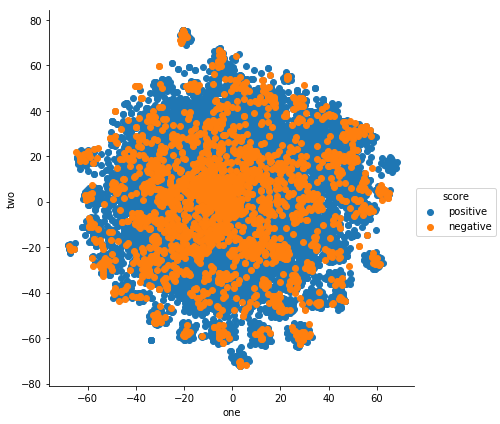

In [21]:
#TSNE
final_2d5 = TSNE(n_components=2,perplexity=35,
                 n_iter=6500).fit_transform(X_svd_scale)
#Stacking df
df = Stacking_df(final_2d5,s.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

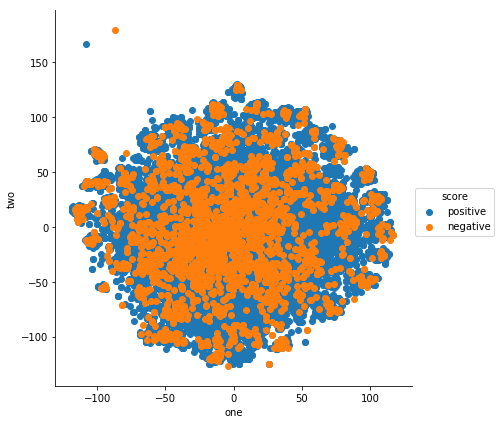

In [22]:
#TSNE
final_2d5 = TSNE(n_components=2,perplexity=10,
                 n_iter=3500).fit_transform(X_svd_scale)
#Stacking df
df = Stacking_df(final_2d5,s.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

* For TFIDF also there is so much overlap and data looks like random

### Word2Vec

In [19]:
#importing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import re

In [20]:
def cleanpunc(sentence): 
    '''
    function to clean the word of any punctuation or special characters
    '''
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [7]:
import gensim
i=0
list_of_sent=[]
for sent in final_amazon.CleanedTextBow.values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [8]:
#word2vec
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=8)    

#### Avg W2V

In [13]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


364171
50


In [18]:
#saving into disk for later use
import pickle
pickle.dump(sent_vectors,open('word2vec.p','wb'))

In [8]:
w2v_array = pickle.load(open('word2vec.p','rb'))

In [9]:
wdf = pd.DataFrame(w2v_array)

In [10]:
#Found one null value row in w2v
wdf[wdf.isnull().any(axis=1)][wdf.columns]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
270507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#row contains total numeric only so we are not considering
cleanpunc(final_amazon.loc[270507].CleanedTextBow)

'&1056;&1077;&1096;&1080;&1083;&1072; &1079;&1072;&1082;&1072;&1079;&1072;&1090;&1100; &1101;&1090;&1080; &1078;&1077;&1083;&1072;&1090;&1080;&1085;&1082;&1080;  &1090; &1082;  &1076;&1086;&1095;&1082;&1072; &1087;&1086;&1096;&1083;&1072; &1074; &1096;&1082;&1086;&1083;&1091; &1080; &1090;&1088;&1077;&1073;&1091;&1077;&1090; &1089;&1083;&1072;&1076;&1086;&1089;&1090;&1080;  &1054;&1095;&1077;&1085;&1100; &1091;&1076;&1086;&1073;&1085;&1072;&1103; &1091;&1087;&1072;&1082;&1086;&1074;&1082;&1072;  &1050;&1072;&1082; &1088;&1072;&1079; &1089;&1090;&1086;&1083;&1100;&1082;&1086; &1082;&1086;&1085;&1092;&1077;&1090;  &1082;&1072;&1082; &1080; &1090;&1088;&1077;&1073;&1091;&1077;&1090;&1089;&1103;  &1095;&1090;&1086;&1073;&1099; &1089;&1100;&1077;&1089;&1090;&1100; &1080;&1093; &1079;&1072; &1087;&1077;&1088;&1077;&1084;&1077;&1085;&1091; '

In [50]:
list_of_sent[270507]

[]

In [11]:
#removing from df
final = final_amazon.drop(final_amazon.index[270507],axis=0)

In [12]:
#droping null
wdf = wdf.dropna()

In [13]:
#Scaling
scaler = StandardScaler()
X_scale=scaler.fit_transform(wdf.values)

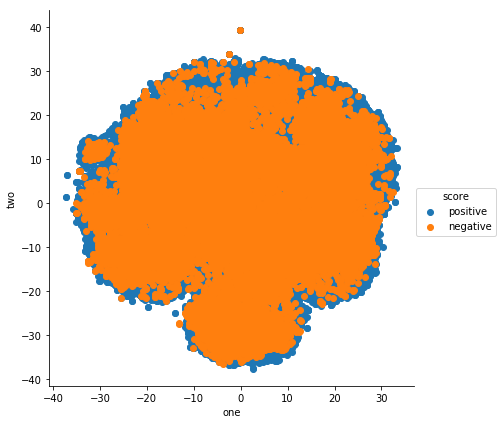

In [58]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=3500,
                  n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

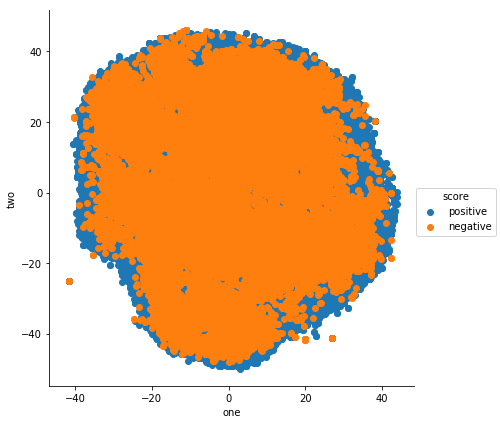

In [18]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=5000,random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [14]:
#sampled some data from above 
s = wdf.sample(n=13000)

In [15]:
#Scaling
scaler = StandardScaler()
X_scale=scaler.fit_transform(s.values)

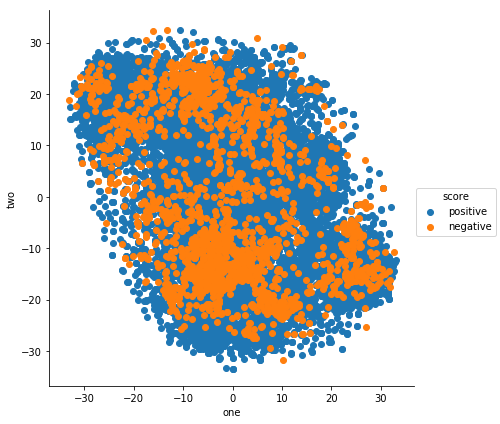

In [29]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=5000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

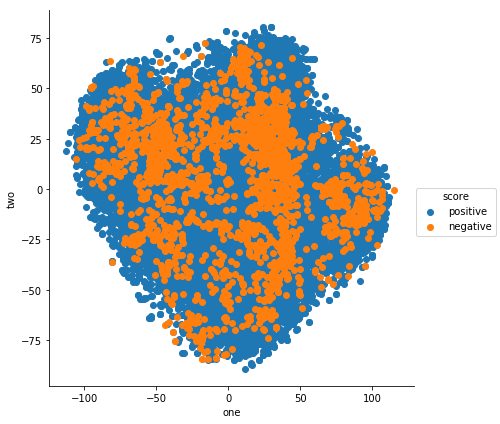

In [31]:
#TSNE
final_2d5 = TSNE(n_components=2,perplexity=35,n_iter=5000,
                 random_state=0).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

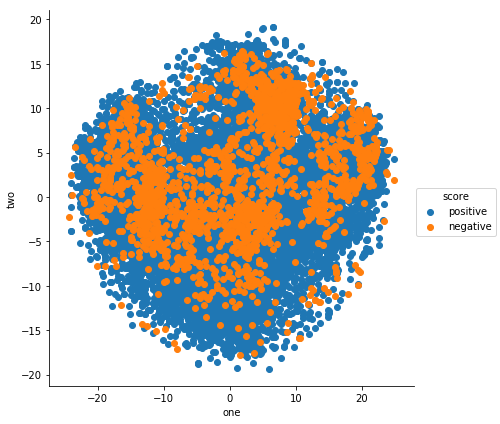

In [16]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=80,n_iter=3800,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

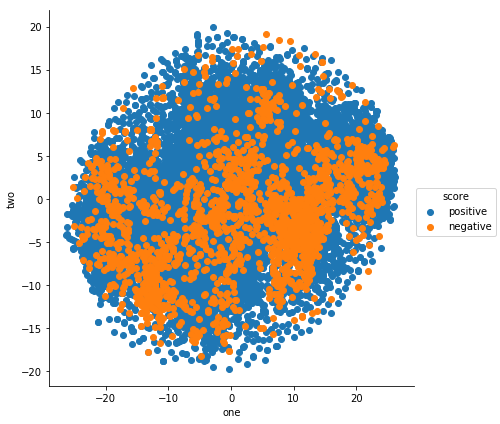

In [17]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=80,n_iter=5800,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

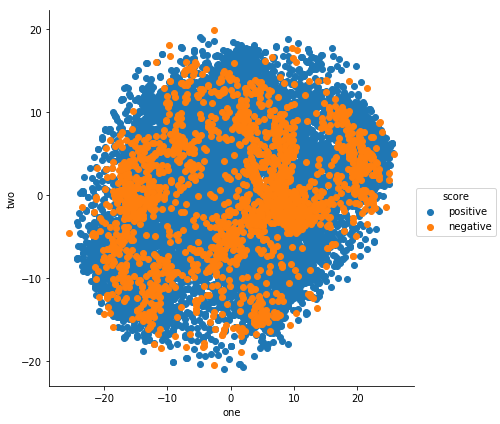

In [18]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=80,n_iter=7800,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

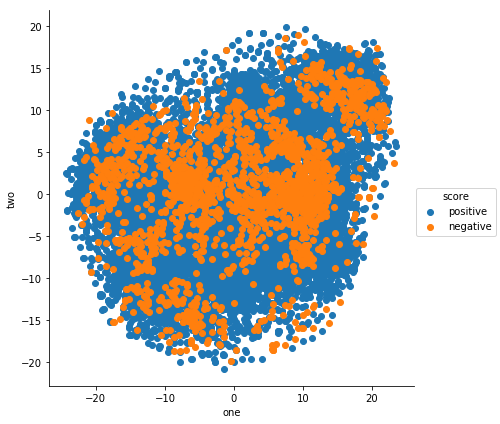

In [19]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=80,n_iter=8800,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

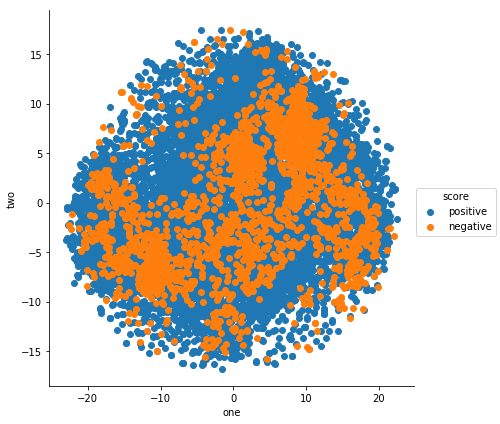

In [20]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=100,n_iter=8800,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

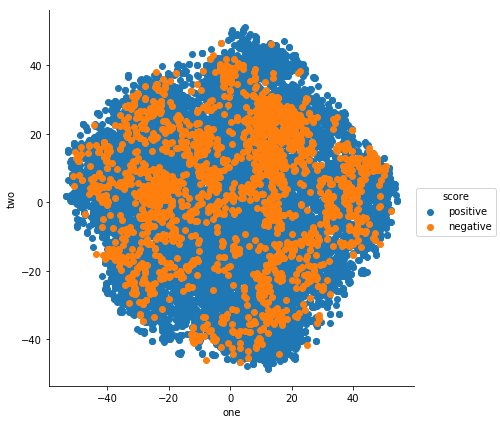

In [21]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=20,n_iter=5000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

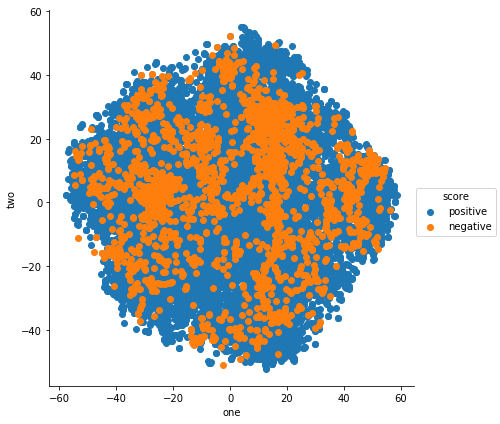

In [22]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=20,n_iter=7000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

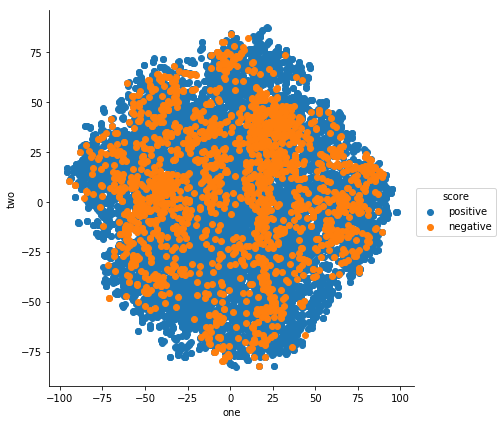

In [23]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=8,
                  n_iter=7000,random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

* Avg Word2Vec also having so much overlap on data for positive and negative instances

#### TF-IDF Weighted Word2Vec

In [9]:
#Cleaning sent
import gensim
i=0
list_of_sent_clean=[]
for sent in final_amazon.CleanedTextBow.values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_clean.append(' '.join(filtered_sentence))

In [10]:
len(list_of_sent_clean)

364171

In [11]:
#tf-idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(list_of_sent_clean)

In [12]:
#convering featues names of tfidf to dict as value = index
#for using in below TFIDF weighted Word2Vec for time efficiency
dict_tfidf = {k: v for v, k in enumerate(tf_idf_vect.get_feature_names())}

In [36]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50,dtype=np.float64) # as word vectors are of zero length
    weight_sum =0.0; # num of words with a valid vector in the sentence/review
    for word in sent : # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            #print(final_tf_idf[row, dict_tfidf[word]])
            # obtain the tf_idfidf of a word in a sentence/review
            #tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            tfidf = final_tf_idf[row, dict_tfidf[word]]
            #print(tfidf)
            #print(np.dot(vec,tf_idf))
            sent_vec = sent_vec + vec*tfidf
            #print(sent_vec)
            weight_sum = weight_sum + tfidf
        except:
            pass
    sent_vec = sent_vec/weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [38]:
len(tfidf_sent_vectors)

364171

In [39]:
#Saving to local file 
pickle.dump(tfidf_sent_vectors,open('tfidf_w2v.p','wb'))

In [7]:
#loading
tfidf_sent_vectors = pickle.load(open('tfidf_w2v.p','rb'))

In [8]:
wdf = pd.DataFrame(tfidf_sent_vectors)
#Found one null value row in w2v
wdf[wdf.isnull().any(axis=1)][wdf.columns]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
138708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#row contains total numeric only so we are not considering
cleanpunc(final_amazon.loc[270507].CleanedTextBow)

'&1056;&1077;&1096;&1080;&1083;&1072; &1079;&1072;&1082;&1072;&1079;&1072;&1090;&1100; &1101;&1090;&1080; &1078;&1077;&1083;&1072;&1090;&1080;&1085;&1082;&1080;  &1090; &1082;  &1076;&1086;&1095;&1082;&1072; &1087;&1086;&1096;&1083;&1072; &1074; &1096;&1082;&1086;&1083;&1091; &1080; &1090;&1088;&1077;&1073;&1091;&1077;&1090; &1089;&1083;&1072;&1076;&1086;&1089;&1090;&1080;  &1054;&1095;&1077;&1085;&1100; &1091;&1076;&1086;&1073;&1085;&1072;&1103; &1091;&1087;&1072;&1082;&1086;&1074;&1082;&1072;  &1050;&1072;&1082; &1088;&1072;&1079; &1089;&1090;&1086;&1083;&1100;&1082;&1086; &1082;&1086;&1085;&1092;&1077;&1090;  &1082;&1072;&1082; &1080; &1090;&1088;&1077;&1073;&1091;&1077;&1090;&1089;&1103;  &1095;&1090;&1086;&1073;&1099; &1089;&1100;&1077;&1089;&1090;&1100; &1080;&1093; &1079;&1072; &1087;&1077;&1088;&1077;&1084;&1077;&1085;&1091; '

In [9]:
#Deletting null entries
final = final_amazon.drop([138708,194901,270507],axis=0)

In [10]:
#deleting nan values
wdf = wdf.dropna()

In [11]:
#Scaling
scaler = StandardScaler()
X_scale=scaler.fit_transform(wdf.values)

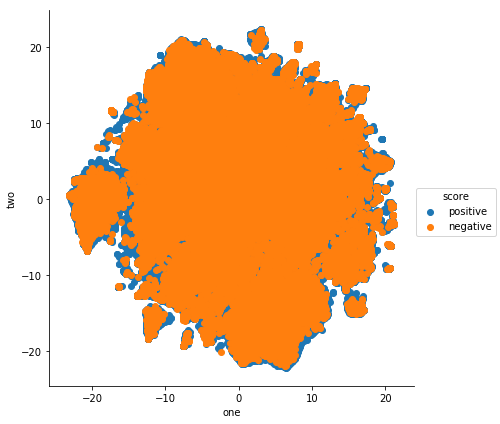

In [50]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=1600,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

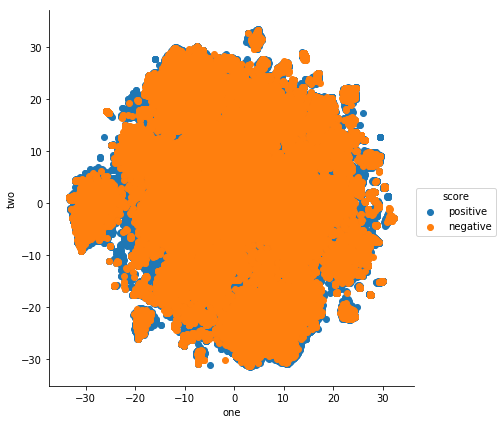

In [51]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=2500,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

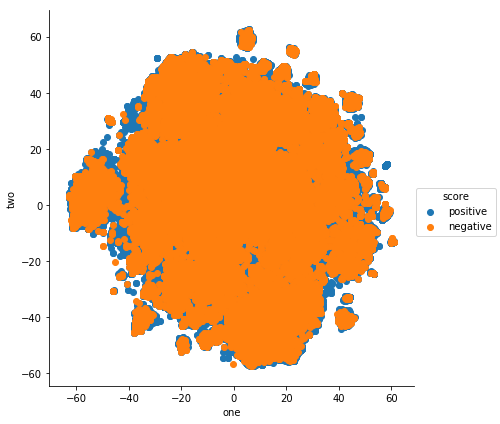

In [14]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=5500,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

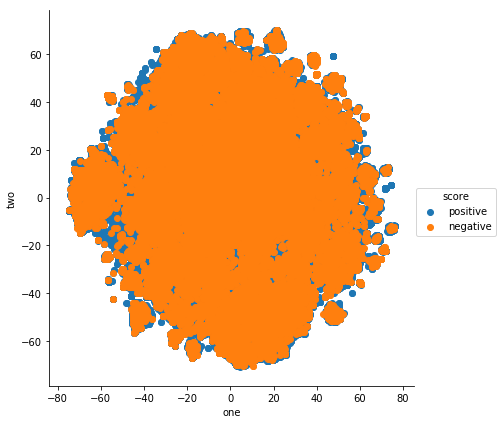

In [15]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=15,n_iter=5500,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final.Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

In [12]:
#Sampling some data
s = wdf.sample(n=13000)
scaler = StandardScaler()
X_scale=scaler.fit_transform(s.values)

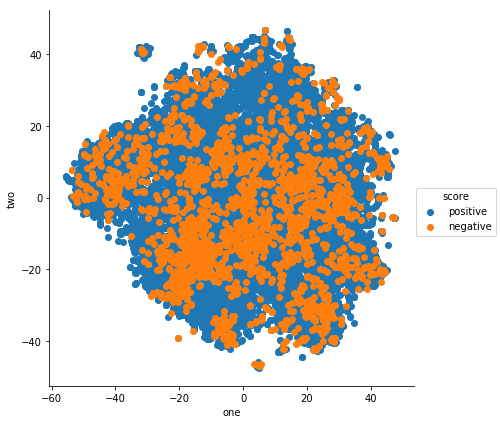

In [17]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=5000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

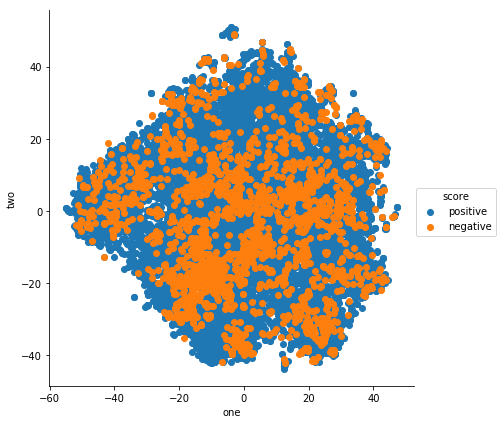

In [18]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=6000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

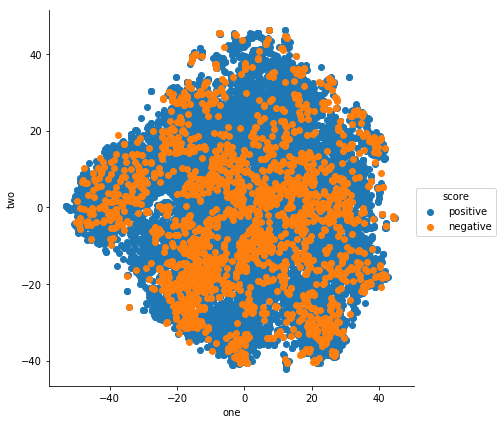

In [19]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=35,n_iter=4000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

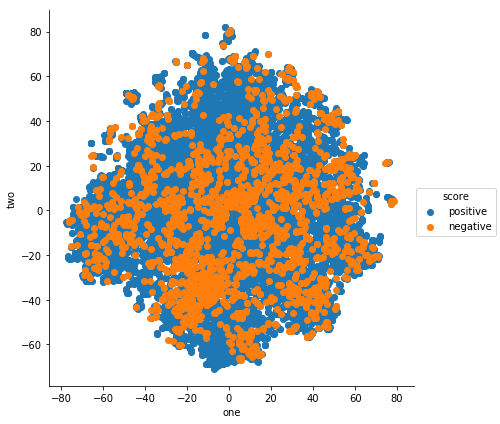

In [20]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=10,n_iter=4000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

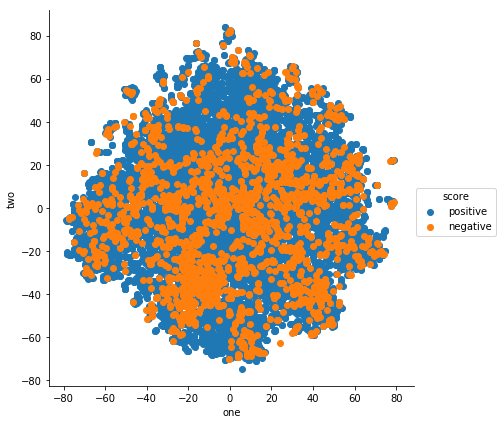

In [22]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=10,n_iter=5000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

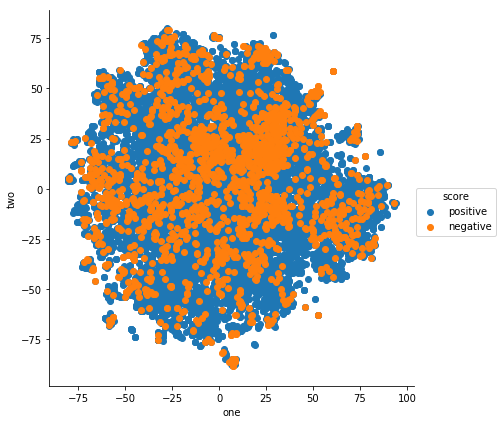

In [13]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=10,n_iter=7000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

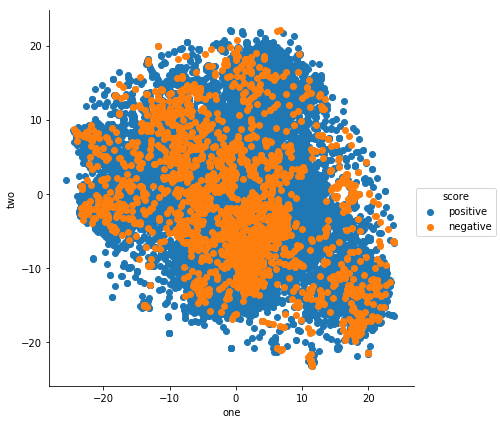

In [14]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=90,n_iter=3000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

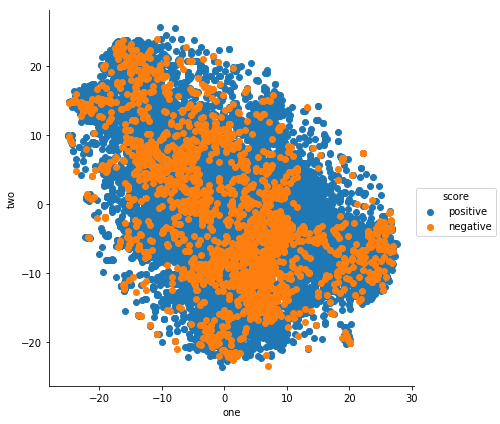

In [15]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=90,n_iter=4000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()

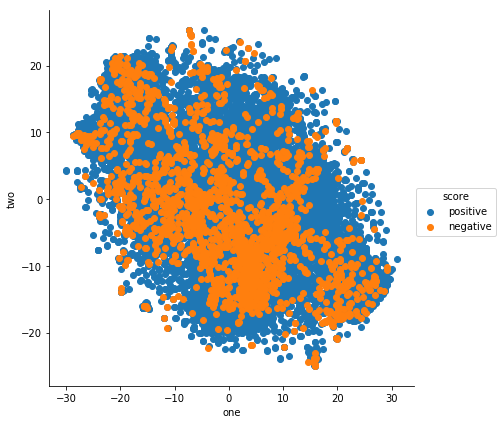

In [16]:
#TSNE
final_2d5 = MTSNE(n_components=2,perplexity=90,n_iter=6000,
                  random_state=0,n_jobs=12).fit_transform(X_scale)
#Stacking df
df = Stacking_df(final_2d5,final_amazon.loc[s.index].Score.values.reshape(-1,1))
#Scatter plot
sns.FacetGrid(df, hue="score", size=6).\
map(plt.scatter,'one','two').add_legend()